In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112)) 
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [18]:
## vary the #of filters in each conv layer
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Choice("Conv1", values=[96,112,120,128]) ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)


        c2 = Convolution2D(filters=hp.Choice("Conv2", values=[96,112,120,128]),kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)

        c2 = Convolution2D(filters=hp.Choice("Conv3", values=[96,112,120,128]),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=hp.Choice("Conv4", values=[96,112,120,128]),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(512)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(256)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(128)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [19]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=1,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [20]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.6064 - acc: 0.4982 - val_loss: 1.4003 - val_acc: 0.6074
Epoch 2/70
2172/2172 - 3s - loss: 1.3603 - acc: 0.5543 - val_loss: 1.1828 - val_acc: 0.6198
Epoch 3/70
2172/2172 - 3s - loss: 1.2208 - acc: 0.5870 - val_loss: 1.9574 - val_acc: 0.6157
Epoch 4/70
2172/2172 - 3s - loss: 1.1187 - acc: 0.6045 - val_loss: 1.2462 - val_acc: 0.5744
Epoch 5/70
2172/2172 - 3s - loss: 1.0894 - acc: 0.6257 - val_loss: 1.3693 - val_acc: 0.4380
Epoch 6/70
2172/2172 - 3s - loss: 1.0919 - acc: 0.6165 - val_loss: 2.4386 - val_acc: 0.5165
Epoch 7/70
2172/2172 - 3s - loss: 1.0558 - acc: 0.6298 - val_loss: 1.2220 - val_acc: 0.4421
Epoch 8/70
2172/2172 - 3s - loss: 1.0233 - acc: 0.6377 - val_loss: 1.0353 - val_acc: 0.6777
Epoch 9/70
2172/2172 - 3s - loss: 0.9486 - acc: 0.6690 - val_loss: 1.1662 - val_acc: 0.5496
Epoch 10/70
2172/2172 - 3s - loss: 0.8770 - acc: 0.6892 - val_loss: 2.0861 - val_acc: 0.1694
Epoch 11/70
2172/2172 - 3s - los

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.5952 - acc: 0.4945 - val_loss: 1.4801 - val_acc: 0.5289
Epoch 2/70
2172/2172 - 3s - loss: 1.3748 - acc: 0.5488 - val_loss: 1.1430 - val_acc: 0.6157
Epoch 3/70
2172/2172 - 3s - loss: 1.2261 - acc: 0.5815 - val_loss: 1.5162 - val_acc: 0.5620
Epoch 4/70
2172/2172 - 3s - loss: 1.1370 - acc: 0.6077 - val_loss: 0.9352 - val_acc: 0.6488
Epoch 5/70
2172/2172 - 3s - loss: 1.0744 - acc: 0.6169 - val_loss: 1.1794 - val_acc: 0.5785
Epoch 6/70
2172/2172 - 3s - loss: 1.0214 - acc: 0.6248 - val_loss: 1.0992 - val_acc: 0.6116
Epoch 7/70
2172/2172 - 3s - loss: 0.9991 - acc: 0.6344 - val_loss: 1.9780 - val_acc: 0.2934
Epoch 8/70
2172/2172 - 3s - loss: 0.9003 - acc: 0.6943 - val_loss: 1.3137 - val_acc: 0.4876
Epoch 9/70
2172/2172 - 3s - loss: 0.8555 - acc: 0.6883 - val_loss: 0.9162 - val_acc: 0.7107
Epoch 10/70
2172/2172 - 3s - loss: 0.8493 - acc: 0.7210 - val_loss: 1.1207 - val_acc: 0.6736
Epoch 11/70
2172/2172 - 3s - los

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.5483 - acc: 0.5152 - val_loss: 1.2685 - val_acc: 0.6322
Epoch 2/70
2172/2172 - 3s - loss: 1.3232 - acc: 0.5599 - val_loss: 1.5605 - val_acc: 0.5909
Epoch 3/70
2172/2172 - 3s - loss: 1.1801 - acc: 0.5916 - val_loss: 1.3619 - val_acc: 0.5579
Epoch 4/70
2172/2172 - 3s - loss: 1.1114 - acc: 0.6064 - val_loss: 2.6774 - val_acc: 0.1860
Epoch 5/70
2172/2172 - 3s - loss: 1.0826 - acc: 0.6169 - val_loss: 4.9465 - val_acc: 0.4711
Epoch 6/70
2172/2172 - 3s - loss: 1.0332 - acc: 0.6215 - val_loss: 1.2359 - val_acc: 0.4959
Epoch 7/70
2172/2172 - 3s - loss: 1.0211 - acc: 0.6349 - val_loss: 1.5940 - val_acc: 0.5826
Epoch 8/70
2172/2172 - 3s - loss: 0.9272 - acc: 0.6690 - val_loss: 0.7886 - val_acc: 0.7025
Epoch 9/70
2172/2172 - 3s - loss: 0.8397 - acc: 0.7109 - val_loss: 2.5089 - val_acc: 0.1653
Epoch 10/70
2172/2172 - 3s - loss: 0.8241 - acc: 0.7118 - val_loss: 1.2084 - val_acc: 0.6074
Epoch 11/70
2172/2172 - 3s - los

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.6118 - acc: 0.5087 - val_loss: 1.3217 - val_acc: 0.6198
Epoch 2/70
2172/2172 - 3s - loss: 1.3601 - acc: 0.5539 - val_loss: 1.1624 - val_acc: 0.6446
Epoch 3/70
2172/2172 - 3s - loss: 1.2317 - acc: 0.5925 - val_loss: 1.3504 - val_acc: 0.5289
Epoch 4/70
2172/2172 - 3s - loss: 1.1606 - acc: 0.6004 - val_loss: 1.3508 - val_acc: 0.5785
Epoch 5/70
2172/2172 - 3s - loss: 1.1029 - acc: 0.6192 - val_loss: 1.5799 - val_acc: 0.4545
Epoch 6/70
2172/2172 - 3s - loss: 1.0539 - acc: 0.6248 - val_loss: 1.4289 - val_acc: 0.6281
Epoch 7/70
2172/2172 - 3s - loss: 0.9726 - acc: 0.6478 - val_loss: 1.1324 - val_acc: 0.6446
Epoch 8/70
2172/2172 - 3s - loss: 0.9004 - acc: 0.6782 - val_loss: 1.0896 - val_acc: 0.6488
Epoch 9/70
2172/2172 - 3s - loss: 0.8947 - acc: 0.6938 - val_loss: 0.9088 - val_acc: 0.6777
Epoch 10/70
2172/2172 - 3s - loss: 0.8331 - acc: 0.7113 - val_loss: 2.7672 - val_acc: 0.4752
Epoch 11/70
2172/2172 - 3s - los

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.5810 - acc: 0.5055 - val_loss: 1.4610 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 3s - loss: 1.3238 - acc: 0.5612 - val_loss: 1.9353 - val_acc: 0.4380
Epoch 3/70
2172/2172 - 3s - loss: 1.1959 - acc: 0.5958 - val_loss: 2.0582 - val_acc: 0.5785
Epoch 4/70
2172/2172 - 3s - loss: 1.1147 - acc: 0.5935 - val_loss: 2.4728 - val_acc: 0.5868
Epoch 5/70
2172/2172 - 3s - loss: 1.0782 - acc: 0.6211 - val_loss: 0.9881 - val_acc: 0.6446
Epoch 6/70
2172/2172 - 3s - loss: 1.0672 - acc: 0.6234 - val_loss: 2.0406 - val_acc: 0.5785
Epoch 7/70
2172/2172 - 3s - loss: 1.0031 - acc: 0.6372 - val_loss: 0.9310 - val_acc: 0.6653
Epoch 8/70
2172/2172 - 3s - loss: 0.9507 - acc: 0.6510 - val_loss: 0.9141 - val_acc: 0.6860
Epoch 9/70
2172/2172 - 3s - loss: 0.8723 - acc: 0.6998 - val_loss: 1.3249 - val_acc: 0.3926
Epoch 10/70
2172/2172 - 3s - loss: 0.8449 - acc: 0.7007 - val_loss: 1.1712 - val_acc: 0.4793
Epoch 11/70
2172/2172 - 3s - los

INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

In [22]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'Conv1': 120, 'Conv2': 96, 'Conv3': 112, 'Conv4': 120}


In [23]:
# best_model = tuner.get_best_models(num_models=1)[0]
model = tuner.hypermodel.build(best_hp)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 120)       480       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 120)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 96)        288096

In [24]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
#               verbose=1, 
              batch_size = 8,
#             class_weight = class_weight
                 callbacks=my_callbacks   )

history_info = history.history

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 [==============================] - ETA: 1:54 - loss: 2.7805 - acc: 0.0000e+0 - ETA: 20s - loss: 2.3991 - acc: 0.1042    - ETA: 12s - loss: 2.0929 - acc: 0.21 - ETA: 9s - loss: 2.0313 - acc: 0.2656 - ETA: 7s - loss: 1.9120 - acc: 0.321 - ETA: 6s - loss: 1.9241 - acc: 0.335 - ETA: 6s - loss: 1.8939 - acc: 0.352 - ETA: 5s - loss: 1.8526 - acc: 0.371 - ETA: 5s - loss: 1.8336 - acc: 0.384 - ETA: 4s - loss: 1.7819 - acc: 0.407 - ETA: 3s - loss: 1.7331 - acc: 0.438 - ETA: 3s - loss: 1.7090 - acc: 0.451 - ETA: 3s - loss: 1.7266 - acc: 0.457 - ETA: 3s - loss: 1.7039 - acc: 0.463 - ETA: 3s - loss: 1.6978 - acc: 0.470 - ETA: 2s - loss: 1.6897 - acc: 0.478 - ETA: 2s - loss: 1.6652 - acc: 0.485 - ETA: 2s - loss: 1.6675 - acc: 0.483 - ETA: 2s - loss: 1.6689 - acc: 0.483 - ETA: 2s - loss: 1.6617 - acc: 0.483 - ETA: 2s - loss: 1.6612 - acc: 0.481 - ETA: 2s - loss: 1.6571 - acc: 0.481 - ETA: 2s - loss: 1.6413 - acc: 0.486 - ETA: 2s - 

2172/2172 [==============================] - ETA: 3s - loss: 1.0377 - acc: 0.625 - ETA: 3s - loss: 1.1295 - acc: 0.625 - ETA: 3s - loss: 1.2447 - acc: 0.555 - ETA: 3s - loss: 1.1744 - acc: 0.572 - ETA: 3s - loss: 1.1641 - acc: 0.591 - ETA: 3s - loss: 1.1549 - acc: 0.585 - ETA: 3s - loss: 1.0775 - acc: 0.620 - ETA: 3s - loss: 1.0661 - acc: 0.621 - ETA: 2s - loss: 1.0673 - acc: 0.621 - ETA: 2s - loss: 1.0612 - acc: 0.618 - ETA: 2s - loss: 1.0761 - acc: 0.605 - ETA: 2s - loss: 1.0900 - acc: 0.602 - ETA: 2s - loss: 1.0846 - acc: 0.613 - ETA: 2s - loss: 1.0943 - acc: 0.610 - ETA: 2s - loss: 1.0980 - acc: 0.608 - ETA: 2s - loss: 1.1029 - acc: 0.608 - ETA: 2s - loss: 1.0996 - acc: 0.605 - ETA: 2s - loss: 1.1071 - acc: 0.601 - ETA: 2s - loss: 1.0900 - acc: 0.610 - ETA: 2s - loss: 1.0840 - acc: 0.609 - ETA: 2s - loss: 1.0820 - acc: 0.607 - ETA: 2s - loss: 1.0857 - acc: 0.605 - ETA: 2s - loss: 1.1109 - acc: 0.596 - ETA: 2s - loss: 1.0973 - acc: 0.600 - ETA: 2s - loss: 1.0975 - acc: 0.602 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 1.0403 - acc: 0.500 - ETA: 4s - loss: 1.0490 - acc: 0.700 - ETA: 3s - loss: 1.0050 - acc: 0.666 - ETA: 3s - loss: 0.9923 - acc: 0.663 - ETA: 3s - loss: 0.9906 - acc: 0.657 - ETA: 2s - loss: 1.0313 - acc: 0.630 - ETA: 2s - loss: 1.0464 - acc: 0.629 - ETA: 2s - loss: 1.0366 - acc: 0.625 - ETA: 2s - loss: 1.0423 - acc: 0.615 - ETA: 2s - loss: 1.0478 - acc: 0.616 - ETA: 2s - loss: 1.0334 - acc: 0.622 - ETA: 2s - loss: 1.0335 - acc: 0.629 - ETA: 2s - loss: 1.0549 - acc: 0.622 - ETA: 2s - loss: 1.0519 - acc: 0.627 - ETA: 2s - loss: 1.0417 - acc: 0.628 - ETA: 2s - loss: 1.0295 - acc: 0.630 - ETA: 2s - loss: 1.0254 - acc: 0.633 - ETA: 2s - loss: 1.0115 - acc: 0.640 - ETA: 2s - loss: 1.0051 - acc: 0.647 - ETA: 1s - loss: 1.0064 - acc: 0.647 - ETA: 1s - loss: 1.0179 - acc: 0.642 - ETA: 1s - loss: 1.0208 - acc: 0.641 - ETA: 1s - loss: 1.0183 - acc: 0.639 - ETA: 1s - loss: 1.0224 - acc: 0.637 - ETA: 1s - loss: 1.0238 - acc: 0.636 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.8798 - acc: 0.500 - ETA: 4s - loss: 1.1900 - acc: 0.625 - ETA: 3s - loss: 0.9280 - acc: 0.715 - ETA: 2s - loss: 0.9007 - acc: 0.703 - ETA: 2s - loss: 0.9307 - acc: 0.696 - ETA: 2s - loss: 0.9122 - acc: 0.705 - ETA: 2s - loss: 0.9511 - acc: 0.685 - ETA: 2s - loss: 0.9458 - acc: 0.689 - ETA: 2s - loss: 0.9379 - acc: 0.689 - ETA: 2s - loss: 0.9442 - acc: 0.673 - ETA: 2s - loss: 0.9689 - acc: 0.652 - ETA: 2s - loss: 1.0775 - acc: 0.640 - ETA: 2s - loss: 1.0654 - acc: 0.634 - ETA: 2s - loss: 1.0707 - acc: 0.625 - ETA: 2s - loss: 1.0581 - acc: 0.632 - ETA: 2s - loss: 1.0380 - acc: 0.643 - ETA: 2s - loss: 1.0264 - acc: 0.651 - ETA: 2s - loss: 1.0384 - acc: 0.643 - ETA: 2s - loss: 1.0419 - acc: 0.643 - ETA: 2s - loss: 1.0430 - acc: 0.641 - ETA: 2s - loss: 1.0426 - acc: 0.640 - ETA: 2s - loss: 1.0462 - acc: 0.642 - ETA: 2s - loss: 1.0486 - acc: 0.640 - ETA: 2s - loss: 1.0578 - acc: 0.636 - ETA: 2s - loss: 1.0500 - acc: 0.638 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.5876 - acc: 0.750 - ETA: 3s - loss: 0.6192 - acc: 0.791 - ETA: 3s - loss: 0.6812 - acc: 0.761 - ETA: 2s - loss: 0.6785 - acc: 0.765 - ETA: 2s - loss: 0.6913 - acc: 0.772 - ETA: 2s - loss: 0.6550 - acc: 0.787 - ETA: 2s - loss: 0.6335 - acc: 0.794 - ETA: 2s - loss: 0.6919 - acc: 0.781 - ETA: 2s - loss: 0.6923 - acc: 0.775 - ETA: 2s - loss: 0.6683 - acc: 0.778 - ETA: 2s - loss: 0.6765 - acc: 0.773 - ETA: 2s - loss: 0.6815 - acc: 0.768 - ETA: 2s - loss: 0.6661 - acc: 0.771 - ETA: 2s - loss: 0.6751 - acc: 0.772 - ETA: 2s - loss: 0.6702 - acc: 0.772 - ETA: 2s - loss: 0.6744 - acc: 0.769 - ETA: 2s - loss: 0.6702 - acc: 0.765 - ETA: 2s - loss: 0.6671 - acc: 0.767 - ETA: 2s - loss: 0.6659 - acc: 0.768 - ETA: 2s - loss: 0.6776 - acc: 0.761 - ETA: 2s - loss: 0.6835 - acc: 0.759 - ETA: 2s - loss: 0.6864 - acc: 0.759 - ETA: 2s - loss: 0.6951 - acc: 0.753 - ETA: 2s - loss: 0.7169 - acc: 0.750 - ETA: 2s - loss: 0.7198 - acc: 0.747 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 1.0077 - acc: 0.500 - ETA: 3s - loss: 0.7417 - acc: 0.729 - ETA: 3s - loss: 0.7453 - acc: 0.737 - ETA: 3s - loss: 0.6857 - acc: 0.758 - ETA: 3s - loss: 0.7266 - acc: 0.750 - ETA: 3s - loss: 0.7016 - acc: 0.761 - ETA: 3s - loss: 0.6915 - acc: 0.754 - ETA: 3s - loss: 0.7245 - acc: 0.741 - ETA: 3s - loss: 0.7006 - acc: 0.760 - ETA: 2s - loss: 0.7140 - acc: 0.759 - ETA: 2s - loss: 0.7009 - acc: 0.769 - ETA: 2s - loss: 0.6908 - acc: 0.769 - ETA: 2s - loss: 0.6660 - acc: 0.781 - ETA: 2s - loss: 0.6765 - acc: 0.780 - ETA: 2s - loss: 0.6934 - acc: 0.776 - ETA: 2s - loss: 0.7062 - acc: 0.772 - ETA: 2s - loss: 0.6993 - acc: 0.773 - ETA: 2s - loss: 0.7058 - acc: 0.769 - ETA: 2s - loss: 0.6962 - acc: 0.768 - ETA: 2s - loss: 0.6875 - acc: 0.770 - ETA: 2s - loss: 0.6907 - acc: 0.772 - ETA: 2s - loss: 0.6922 - acc: 0.771 - ETA: 1s - loss: 0.6808 - acc: 0.771 - ETA: 1s - loss: 0.6734 - acc: 0.775 - ETA: 1s - loss: 0.6690 - acc: 0.773 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0312 - acc: 1.000 - ETA: 2s - loss: 0.6299 - acc: 0.812 - ETA: 2s - loss: 0.5657 - acc: 0.817 - ETA: 2s - loss: 0.4981 - acc: 0.847 - ETA: 2s - loss: 0.5245 - acc: 0.835 - ETA: 2s - loss: 0.5316 - acc: 0.836 - ETA: 2s - loss: 0.4899 - acc: 0.850 - ETA: 2s - loss: 0.4891 - acc: 0.838 - ETA: 2s - loss: 0.4926 - acc: 0.840 - ETA: 2s - loss: 0.5229 - acc: 0.834 - ETA: 2s - loss: 0.5210 - acc: 0.836 - ETA: 2s - loss: 0.5428 - acc: 0.831 - ETA: 2s - loss: 0.5461 - acc: 0.829 - ETA: 2s - loss: 0.5457 - acc: 0.830 - ETA: 2s - loss: 0.5620 - acc: 0.828 - ETA: 2s - loss: 0.5817 - acc: 0.816 - ETA: 2s - loss: 0.5695 - acc: 0.818 - ETA: 2s - loss: 0.5956 - acc: 0.817 - ETA: 2s - loss: 0.6148 - acc: 0.809 - ETA: 2s - loss: 0.6165 - acc: 0.808 - ETA: 2s - loss: 0.6117 - acc: 0.808 - ETA: 1s - loss: 0.6058 - acc: 0.810 - ETA: 1s - loss: 0.6116 - acc: 0.811 - ETA: 1s - loss: 0.6053 - acc: 0.811 - ETA: 1s - loss: 0.6066 - acc: 0.813 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2496 - acc: 0.875 - ETA: 4s - loss: 0.3382 - acc: 0.900 - ETA: 4s - loss: 0.3768 - acc: 0.888 - ETA: 3s - loss: 0.4594 - acc: 0.846 - ETA: 3s - loss: 0.3850 - acc: 0.875 - ETA: 3s - loss: 0.3599 - acc: 0.886 - ETA: 3s - loss: 0.3773 - acc: 0.870 - ETA: 3s - loss: 0.3522 - acc: 0.878 - ETA: 3s - loss: 0.3678 - acc: 0.868 - ETA: 3s - loss: 0.3543 - acc: 0.871 - ETA: 2s - loss: 0.3493 - acc: 0.875 - ETA: 2s - loss: 0.3515 - acc: 0.875 - ETA: 2s - loss: 0.3528 - acc: 0.879 - ETA: 2s - loss: 0.3644 - acc: 0.877 - ETA: 2s - loss: 0.3572 - acc: 0.877 - ETA: 2s - loss: 0.3583 - acc: 0.875 - ETA: 2s - loss: 0.3691 - acc: 0.869 - ETA: 2s - loss: 0.3705 - acc: 0.870 - ETA: 2s - loss: 0.3769 - acc: 0.867 - ETA: 2s - loss: 0.3778 - acc: 0.866 - ETA: 2s - loss: 0.3821 - acc: 0.866 - ETA: 2s - loss: 0.4214 - acc: 0.861 - ETA: 2s - loss: 0.4202 - acc: 0.860 - ETA: 2s - loss: 0.4277 - acc: 0.857 - ETA: 2s - loss: 0.4272 - acc: 0.854 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2056 - acc: 1.000 - ETA: 2s - loss: 0.3975 - acc: 0.892 - ETA: 2s - loss: 0.3658 - acc: 0.903 - ETA: 2s - loss: 0.3474 - acc: 0.901 - ETA: 2s - loss: 0.3621 - acc: 0.890 - ETA: 2s - loss: 0.3573 - acc: 0.892 - ETA: 2s - loss: 0.4046 - acc: 0.867 - ETA: 2s - loss: 0.3899 - acc: 0.878 - ETA: 2s - loss: 0.3754 - acc: 0.880 - ETA: 2s - loss: 0.3770 - acc: 0.882 - ETA: 2s - loss: 0.3737 - acc: 0.879 - ETA: 2s - loss: 0.3798 - acc: 0.877 - ETA: 2s - loss: 0.3951 - acc: 0.873 - ETA: 2s - loss: 0.3992 - acc: 0.867 - ETA: 2s - loss: 0.4018 - acc: 0.865 - ETA: 2s - loss: 0.4004 - acc: 0.868 - ETA: 2s - loss: 0.3933 - acc: 0.870 - ETA: 2s - loss: 0.3877 - acc: 0.873 - ETA: 2s - loss: 0.3880 - acc: 0.873 - ETA: 2s - loss: 0.3911 - acc: 0.870 - ETA: 2s - loss: 0.3873 - acc: 0.870 - ETA: 2s - loss: 0.3900 - acc: 0.869 - ETA: 2s - loss: 0.3947 - acc: 0.869 - ETA: 2s - loss: 0.3983 - acc: 0.868 - ETA: 2s - loss: 0.4039 - acc: 0.867 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.5573 - acc: 0.750 - ETA: 4s - loss: 0.6914 - acc: 0.656 - ETA: 4s - loss: 0.5884 - acc: 0.750 - ETA: 4s - loss: 0.4780 - acc: 0.812 - ETA: 4s - loss: 0.4924 - acc: 0.817 - ETA: 4s - loss: 0.4263 - acc: 0.843 - ETA: 4s - loss: 0.4021 - acc: 0.855 - ETA: 4s - loss: 0.3944 - acc: 0.858 - ETA: 4s - loss: 0.3971 - acc: 0.855 - ETA: 3s - loss: 0.3931 - acc: 0.854 - ETA: 3s - loss: 0.3694 - acc: 0.864 - ETA: 3s - loss: 0.3702 - acc: 0.865 - ETA: 3s - loss: 0.3640 - acc: 0.869 - ETA: 3s - loss: 0.3813 - acc: 0.865 - ETA: 3s - loss: 0.3865 - acc: 0.863 - ETA: 3s - loss: 0.3793 - acc: 0.864 - ETA: 2s - loss: 0.3700 - acc: 0.864 - ETA: 2s - loss: 0.3685 - acc: 0.867 - ETA: 2s - loss: 0.3652 - acc: 0.867 - ETA: 2s - loss: 0.3886 - acc: 0.861 - ETA: 2s - loss: 0.3926 - acc: 0.857 - ETA: 2s - loss: 0.3926 - acc: 0.859 - ETA: 2s - loss: 0.3895 - acc: 0.861 - ETA: 2s - loss: 0.3870 - acc: 0.865 - ETA: 2s - loss: 0.3937 - acc: 0.861 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1700 - acc: 0.875 - ETA: 3s - loss: 0.2811 - acc: 0.895 - ETA: 3s - loss: 0.2791 - acc: 0.912 - ETA: 3s - loss: 0.3510 - acc: 0.903 - ETA: 3s - loss: 0.3648 - acc: 0.890 - ETA: 4s - loss: 0.4002 - acc: 0.868 - ETA: 4s - loss: 0.4097 - acc: 0.858 - ETA: 4s - loss: 0.4133 - acc: 0.850 - ETA: 4s - loss: 0.3972 - acc: 0.857 - ETA: 3s - loss: 0.4427 - acc: 0.848 - ETA: 3s - loss: 0.4380 - acc: 0.848 - ETA: 3s - loss: 0.4277 - acc: 0.851 - ETA: 3s - loss: 0.4179 - acc: 0.849 - ETA: 3s - loss: 0.4321 - acc: 0.844 - ETA: 3s - loss: 0.4159 - acc: 0.849 - ETA: 2s - loss: 0.4214 - acc: 0.854 - ETA: 2s - loss: 0.4090 - acc: 0.858 - ETA: 2s - loss: 0.4065 - acc: 0.857 - ETA: 2s - loss: 0.4009 - acc: 0.859 - ETA: 2s - loss: 0.4001 - acc: 0.855 - ETA: 2s - loss: 0.4153 - acc: 0.853 - ETA: 2s - loss: 0.4190 - acc: 0.850 - ETA: 2s - loss: 0.4150 - acc: 0.850 - ETA: 2s - loss: 0.4237 - acc: 0.848 - ETA: 2s - loss: 0.4163 - acc: 0.852 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2218 - acc: 0.875 - ETA: 3s - loss: 0.3284 - acc: 0.900 - ETA: 3s - loss: 0.2761 - acc: 0.902 - ETA: 2s - loss: 0.2562 - acc: 0.916 - ETA: 2s - loss: 0.3726 - acc: 0.892 - ETA: 2s - loss: 0.3362 - acc: 0.908 - ETA: 2s - loss: 0.3245 - acc: 0.907 - ETA: 2s - loss: 0.3973 - acc: 0.892 - ETA: 2s - loss: 0.3938 - acc: 0.887 - ETA: 2s - loss: 0.3686 - acc: 0.894 - ETA: 2s - loss: 0.3941 - acc: 0.885 - ETA: 2s - loss: 0.4543 - acc: 0.868 - ETA: 2s - loss: 0.4666 - acc: 0.864 - ETA: 2s - loss: 0.4683 - acc: 0.858 - ETA: 2s - loss: 0.4614 - acc: 0.859 - ETA: 2s - loss: 0.4573 - acc: 0.857 - ETA: 1s - loss: 0.4584 - acc: 0.860 - ETA: 1s - loss: 0.4414 - acc: 0.865 - ETA: 1s - loss: 0.4306 - acc: 0.867 - ETA: 1s - loss: 0.4130 - acc: 0.873 - ETA: 1s - loss: 0.4044 - acc: 0.878 - ETA: 1s - loss: 0.3918 - acc: 0.882 - ETA: 1s - loss: 0.3822 - acc: 0.884 - ETA: 1s - loss: 0.3782 - acc: 0.885 - ETA: 1s - loss: 0.3741 - acc: 0.886 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2511 - acc: 0.875 - ETA: 4s - loss: 0.3502 - acc: 0.875 - ETA: 4s - loss: 0.2675 - acc: 0.921 - ETA: 3s - loss: 0.2668 - acc: 0.913 - ETA: 3s - loss: 0.3013 - acc: 0.895 - ETA: 3s - loss: 0.4108 - acc: 0.864 - ETA: 3s - loss: 0.4448 - acc: 0.848 - ETA: 2s - loss: 0.4294 - acc: 0.856 - ETA: 2s - loss: 0.3925 - acc: 0.875 - ETA: 2s - loss: 0.3990 - acc: 0.875 - ETA: 2s - loss: 0.3929 - acc: 0.869 - ETA: 2s - loss: 0.3899 - acc: 0.872 - ETA: 2s - loss: 0.3706 - acc: 0.881 - ETA: 2s - loss: 0.3662 - acc: 0.881 - ETA: 2s - loss: 0.3644 - acc: 0.878 - ETA: 2s - loss: 0.3506 - acc: 0.884 - ETA: 2s - loss: 0.3382 - acc: 0.888 - ETA: 2s - loss: 0.3260 - acc: 0.892 - ETA: 2s - loss: 0.3169 - acc: 0.895 - ETA: 2s - loss: 0.3234 - acc: 0.891 - ETA: 2s - loss: 0.3188 - acc: 0.893 - ETA: 1s - loss: 0.3199 - acc: 0.889 - ETA: 1s - loss: 0.3375 - acc: 0.890 - ETA: 1s - loss: 0.3370 - acc: 0.887 - ETA: 1s - loss: 0.3388 - acc: 0.886 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4540 - acc: 0.875 - ETA: 4s - loss: 0.1966 - acc: 0.968 - ETA: 4s - loss: 0.2122 - acc: 0.946 - ETA: 4s - loss: 0.2110 - acc: 0.950 - ETA: 4s - loss: 0.2117 - acc: 0.946 - ETA: 3s - loss: 0.2086 - acc: 0.953 - ETA: 3s - loss: 0.2340 - acc: 0.940 - ETA: 3s - loss: 0.2319 - acc: 0.939 - ETA: 3s - loss: 0.2582 - acc: 0.923 - ETA: 3s - loss: 0.2579 - acc: 0.921 - ETA: 3s - loss: 0.2797 - acc: 0.913 - ETA: 3s - loss: 0.3022 - acc: 0.900 - ETA: 2s - loss: 0.3440 - acc: 0.887 - ETA: 2s - loss: 0.3601 - acc: 0.879 - ETA: 2s - loss: 0.3570 - acc: 0.881 - ETA: 2s - loss: 0.3479 - acc: 0.882 - ETA: 2s - loss: 0.3367 - acc: 0.885 - ETA: 2s - loss: 0.3527 - acc: 0.881 - ETA: 2s - loss: 0.3553 - acc: 0.879 - ETA: 2s - loss: 0.3659 - acc: 0.875 - ETA: 2s - loss: 0.3581 - acc: 0.880 - ETA: 2s - loss: 0.3560 - acc: 0.877 - ETA: 2s - loss: 0.3616 - acc: 0.875 - ETA: 2s - loss: 0.3663 - acc: 0.872 - ETA: 2s - loss: 0.3650 - acc: 0.872 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.4449 - acc: 0.875 - ETA: 5s - loss: 0.2978 - acc: 0.906 - ETA: 3s - loss: 0.3644 - acc: 0.888 - ETA: 3s - loss: 0.3103 - acc: 0.916 - ETA: 2s - loss: 0.3173 - acc: 0.906 - ETA: 2s - loss: 0.3239 - acc: 0.900 - ETA: 2s - loss: 0.2869 - acc: 0.912 - ETA: 2s - loss: 0.2676 - acc: 0.917 - ETA: 2s - loss: 0.2533 - acc: 0.918 - ETA: 2s - loss: 0.2580 - acc: 0.923 - ETA: 2s - loss: 0.2618 - acc: 0.921 - ETA: 2s - loss: 0.2674 - acc: 0.918 - ETA: 2s - loss: 0.2730 - acc: 0.917 - ETA: 2s - loss: 0.2728 - acc: 0.913 - ETA: 2s - loss: 0.2773 - acc: 0.912 - ETA: 2s - loss: 0.2765 - acc: 0.914 - ETA: 2s - loss: 0.2659 - acc: 0.918 - ETA: 2s - loss: 0.2621 - acc: 0.920 - ETA: 2s - loss: 0.2578 - acc: 0.921 - ETA: 1s - loss: 0.2488 - acc: 0.925 - ETA: 1s - loss: 0.2558 - acc: 0.923 - ETA: 1s - loss: 0.2747 - acc: 0.920 - ETA: 1s - loss: 0.2723 - acc: 0.921 - ETA: 1s - loss: 0.2747 - acc: 0.922 - ETA: 1s - loss: 0.2794 - acc: 0.920 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.7078 - acc: 0.750 - ETA: 3s - loss: 0.3290 - acc: 0.895 - ETA: 3s - loss: 0.4668 - acc: 0.840 - ETA: 2s - loss: 0.4855 - acc: 0.845 - ETA: 2s - loss: 0.4161 - acc: 0.869 - ETA: 2s - loss: 0.3694 - acc: 0.888 - ETA: 2s - loss: 0.3620 - acc: 0.890 - ETA: 2s - loss: 0.4131 - acc: 0.868 - ETA: 2s - loss: 0.4044 - acc: 0.865 - ETA: 2s - loss: 0.4014 - acc: 0.869 - ETA: 2s - loss: 0.3984 - acc: 0.867 - ETA: 2s - loss: 0.3855 - acc: 0.870 - ETA: 2s - loss: 0.3671 - acc: 0.877 - ETA: 2s - loss: 0.3837 - acc: 0.873 - ETA: 2s - loss: 0.3920 - acc: 0.869 - ETA: 2s - loss: 0.3940 - acc: 0.868 - ETA: 2s - loss: 0.3874 - acc: 0.868 - ETA: 2s - loss: 0.3813 - acc: 0.872 - ETA: 2s - loss: 0.3735 - acc: 0.873 - ETA: 2s - loss: 0.3775 - acc: 0.872 - ETA: 2s - loss: 0.3738 - acc: 0.875 - ETA: 2s - loss: 0.3717 - acc: 0.877 - ETA: 2s - loss: 0.3698 - acc: 0.878 - ETA: 1s - loss: 0.3754 - acc: 0.876 - ETA: 1s - loss: 0.3699 - acc: 0.877 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.3019 - acc: 0.875 - ETA: 2s - loss: 0.4146 - acc: 0.854 - ETA: 2s - loss: 0.3391 - acc: 0.897 - ETA: 2s - loss: 0.3201 - acc: 0.906 - ETA: 2s - loss: 0.3348 - acc: 0.892 - ETA: 2s - loss: 0.2936 - acc: 0.897 - ETA: 2s - loss: 0.2789 - acc: 0.901 - ETA: 2s - loss: 0.2926 - acc: 0.902 - ETA: 2s - loss: 0.2968 - acc: 0.902 - ETA: 2s - loss: 0.2824 - acc: 0.908 - ETA: 2s - loss: 0.2826 - acc: 0.908 - ETA: 2s - loss: 0.2816 - acc: 0.908 - ETA: 2s - loss: 0.2749 - acc: 0.909 - ETA: 2s - loss: 0.3053 - acc: 0.898 - ETA: 2s - loss: 0.3092 - acc: 0.895 - ETA: 2s - loss: 0.3058 - acc: 0.897 - ETA: 2s - loss: 0.2952 - acc: 0.902 - ETA: 2s - loss: 0.2925 - acc: 0.900 - ETA: 2s - loss: 0.2916 - acc: 0.900 - ETA: 1s - loss: 0.2892 - acc: 0.901 - ETA: 1s - loss: 0.2928 - acc: 0.900 - ETA: 1s - loss: 0.2883 - acc: 0.901 - ETA: 1s - loss: 0.2835 - acc: 0.904 - ETA: 1s - loss: 0.2861 - acc: 0.904 - ETA: 1s - loss: 0.2887 - acc: 0.905 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 1.1694 - acc: 0.625 - ETA: 2s - loss: 0.2961 - acc: 0.916 - ETA: 2s - loss: 0.2852 - acc: 0.920 - ETA: 2s - loss: 0.2755 - acc: 0.921 - ETA: 2s - loss: 0.3190 - acc: 0.910 - ETA: 2s - loss: 0.3980 - acc: 0.885 - ETA: 2s - loss: 0.3877 - acc: 0.883 - ETA: 2s - loss: 0.3999 - acc: 0.878 - ETA: 2s - loss: 0.3665 - acc: 0.891 - ETA: 2s - loss: 0.3554 - acc: 0.892 - ETA: 2s - loss: 0.3465 - acc: 0.893 - ETA: 2s - loss: 0.3351 - acc: 0.896 - ETA: 2s - loss: 0.3406 - acc: 0.896 - ETA: 2s - loss: 0.3271 - acc: 0.901 - ETA: 2s - loss: 0.3262 - acc: 0.901 - ETA: 2s - loss: 0.3147 - acc: 0.901 - ETA: 2s - loss: 0.3178 - acc: 0.901 - ETA: 2s - loss: 0.3086 - acc: 0.904 - ETA: 2s - loss: 0.3031 - acc: 0.904 - ETA: 2s - loss: 0.3053 - acc: 0.898 - ETA: 1s - loss: 0.3017 - acc: 0.897 - ETA: 1s - loss: 0.2905 - acc: 0.902 - ETA: 1s - loss: 0.2836 - acc: 0.904 - ETA: 1s - loss: 0.2858 - acc: 0.902 - ETA: 1s - loss: 0.2853 - acc: 0.904 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0594 - acc: 1.000 - ETA: 3s - loss: 0.4129 - acc: 0.875 - ETA: 3s - loss: 0.2670 - acc: 0.920 - ETA: 2s - loss: 0.2287 - acc: 0.926 - ETA: 2s - loss: 0.2486 - acc: 0.907 - ETA: 2s - loss: 0.2744 - acc: 0.906 - ETA: 2s - loss: 0.2688 - acc: 0.905 - ETA: 2s - loss: 0.2481 - acc: 0.914 - ETA: 2s - loss: 0.2320 - acc: 0.918 - ETA: 2s - loss: 0.2336 - acc: 0.916 - ETA: 2s - loss: 0.2299 - acc: 0.917 - ETA: 2s - loss: 0.2290 - acc: 0.915 - ETA: 2s - loss: 0.2201 - acc: 0.920 - ETA: 2s - loss: 0.2134 - acc: 0.921 - ETA: 2s - loss: 0.2118 - acc: 0.923 - ETA: 2s - loss: 0.2126 - acc: 0.923 - ETA: 2s - loss: 0.2645 - acc: 0.917 - ETA: 2s - loss: 0.2555 - acc: 0.917 - ETA: 2s - loss: 0.2785 - acc: 0.919 - ETA: 2s - loss: 0.2939 - acc: 0.914 - ETA: 2s - loss: 0.2980 - acc: 0.913 - ETA: 2s - loss: 0.2974 - acc: 0.914 - ETA: 1s - loss: 0.2916 - acc: 0.913 - ETA: 1s - loss: 0.2882 - acc: 0.914 - ETA: 1s - loss: 0.2876 - acc: 0.915 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0550 - acc: 1.000 - ETA: 4s - loss: 0.1569 - acc: 0.937 - ETA: 3s - loss: 0.2278 - acc: 0.925 - ETA: 2s - loss: 0.2206 - acc: 0.921 - ETA: 2s - loss: 0.2615 - acc: 0.910 - ETA: 2s - loss: 0.2453 - acc: 0.915 - ETA: 2s - loss: 0.2489 - acc: 0.911 - ETA: 2s - loss: 0.2623 - acc: 0.910 - ETA: 2s - loss: 0.2735 - acc: 0.910 - ETA: 2s - loss: 0.2725 - acc: 0.908 - ETA: 2s - loss: 0.2630 - acc: 0.910 - ETA: 2s - loss: 0.2600 - acc: 0.911 - ETA: 2s - loss: 0.2547 - acc: 0.913 - ETA: 2s - loss: 0.2538 - acc: 0.914 - ETA: 2s - loss: 0.2517 - acc: 0.915 - ETA: 2s - loss: 0.2607 - acc: 0.914 - ETA: 2s - loss: 0.2582 - acc: 0.915 - ETA: 2s - loss: 0.2513 - acc: 0.916 - ETA: 2s - loss: 0.2482 - acc: 0.917 - ETA: 2s - loss: 0.2342 - acc: 0.923 - ETA: 1s - loss: 0.2328 - acc: 0.923 - ETA: 1s - loss: 0.2282 - acc: 0.924 - ETA: 1s - loss: 0.2300 - acc: 0.920 - ETA: 1s - loss: 0.2256 - acc: 0.922 - ETA: 1s - loss: 0.2259 - acc: 0.921 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0634 - acc: 1.000 - ETA: 4s - loss: 0.1321 - acc: 0.968 - ETA: 4s - loss: 0.1044 - acc: 0.964 - ETA: 4s - loss: 0.1017 - acc: 0.962 - ETA: 4s - loss: 0.1976 - acc: 0.928 - ETA: 5s - loss: 0.2060 - acc: 0.921 - ETA: 5s - loss: 0.2096 - acc: 0.921 - ETA: 5s - loss: 0.1969 - acc: 0.926 - ETA: 5s - loss: 0.1878 - acc: 0.930 - ETA: 5s - loss: 0.1774 - acc: 0.933 - ETA: 4s - loss: 0.1840 - acc: 0.931 - ETA: 4s - loss: 0.1971 - acc: 0.926 - ETA: 4s - loss: 0.1933 - acc: 0.922 - ETA: 4s - loss: 0.1995 - acc: 0.919 - ETA: 4s - loss: 0.1822 - acc: 0.928 - ETA: 3s - loss: 0.1734 - acc: 0.932 - ETA: 3s - loss: 0.1691 - acc: 0.938 - ETA: 3s - loss: 0.1734 - acc: 0.939 - ETA: 3s - loss: 0.1801 - acc: 0.939 - ETA: 3s - loss: 0.1753 - acc: 0.941 - ETA: 3s - loss: 0.1826 - acc: 0.937 - ETA: 3s - loss: 0.1755 - acc: 0.940 - ETA: 2s - loss: 0.1730 - acc: 0.942 - ETA: 2s - loss: 0.1810 - acc: 0.940 - ETA: 2s - loss: 0.1838 - acc: 0.938 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0214 - acc: 1.000 - ETA: 3s - loss: 0.2745 - acc: 0.895 - ETA: 3s - loss: 0.2178 - acc: 0.925 - ETA: 2s - loss: 0.2219 - acc: 0.925 - ETA: 2s - loss: 0.2105 - acc: 0.925 - ETA: 2s - loss: 0.2172 - acc: 0.927 - ETA: 2s - loss: 0.2001 - acc: 0.935 - ETA: 2s - loss: 0.1893 - acc: 0.941 - ETA: 2s - loss: 0.1795 - acc: 0.945 - ETA: 2s - loss: 0.1727 - acc: 0.945 - ETA: 2s - loss: 0.1656 - acc: 0.947 - ETA: 2s - loss: 0.1641 - acc: 0.949 - ETA: 2s - loss: 0.1675 - acc: 0.948 - ETA: 2s - loss: 0.1623 - acc: 0.949 - ETA: 2s - loss: 0.1615 - acc: 0.947 - ETA: 2s - loss: 0.1665 - acc: 0.946 - ETA: 2s - loss: 0.1591 - acc: 0.949 - ETA: 2s - loss: 0.1511 - acc: 0.951 - ETA: 2s - loss: 0.1623 - acc: 0.947 - ETA: 2s - loss: 0.1637 - acc: 0.948 - ETA: 1s - loss: 0.1619 - acc: 0.949 - ETA: 1s - loss: 0.1662 - acc: 0.946 - ETA: 1s - loss: 0.1675 - acc: 0.945 - ETA: 1s - loss: 0.1624 - acc: 0.946 - ETA: 1s - loss: 0.1710 - acc: 0.945 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1296 - acc: 1.000 - ETA: 3s - loss: 0.1547 - acc: 0.950 - ETA: 4s - loss: 0.1415 - acc: 0.953 - ETA: 3s - loss: 0.1608 - acc: 0.958 - ETA: 3s - loss: 0.1769 - acc: 0.960 - ETA: 3s - loss: 0.1583 - acc: 0.962 - ETA: 2s - loss: 0.1683 - acc: 0.955 - ETA: 2s - loss: 0.1809 - acc: 0.954 - ETA: 2s - loss: 0.1801 - acc: 0.958 - ETA: 2s - loss: 0.1880 - acc: 0.950 - ETA: 2s - loss: 0.1822 - acc: 0.952 - ETA: 2s - loss: 0.1763 - acc: 0.952 - ETA: 2s - loss: 0.1676 - acc: 0.952 - ETA: 2s - loss: 0.1592 - acc: 0.955 - ETA: 2s - loss: 0.1814 - acc: 0.949 - ETA: 2s - loss: 0.1820 - acc: 0.949 - ETA: 2s - loss: 0.1741 - acc: 0.950 - ETA: 2s - loss: 0.1694 - acc: 0.952 - ETA: 2s - loss: 0.1727 - acc: 0.951 - ETA: 2s - loss: 0.1654 - acc: 0.953 - ETA: 1s - loss: 0.1649 - acc: 0.952 - ETA: 1s - loss: 0.1631 - acc: 0.951 - ETA: 1s - loss: 0.1605 - acc: 0.951 - ETA: 1s - loss: 0.1591 - acc: 0.950 - ETA: 1s - loss: 0.1584 - acc: 0.950 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4227 - acc: 0.750 - ETA: 4s - loss: 0.1902 - acc: 0.950 - ETA: 3s - loss: 0.1860 - acc: 0.958 - ETA: 3s - loss: 0.1379 - acc: 0.968 - ETA: 2s - loss: 0.1294 - acc: 0.972 - ETA: 2s - loss: 0.1318 - acc: 0.967 - ETA: 2s - loss: 0.1363 - acc: 0.965 - ETA: 2s - loss: 0.1323 - acc: 0.961 - ETA: 2s - loss: 0.1479 - acc: 0.959 - ETA: 2s - loss: 0.1530 - acc: 0.957 - ETA: 2s - loss: 0.1476 - acc: 0.955 - ETA: 2s - loss: 0.1680 - acc: 0.949 - ETA: 2s - loss: 0.1696 - acc: 0.947 - ETA: 2s - loss: 0.1701 - acc: 0.948 - ETA: 2s - loss: 0.1740 - acc: 0.944 - ETA: 2s - loss: 0.1712 - acc: 0.945 - ETA: 2s - loss: 0.1646 - acc: 0.947 - ETA: 2s - loss: 0.1637 - acc: 0.948 - ETA: 2s - loss: 0.1601 - acc: 0.950 - ETA: 2s - loss: 0.1639 - acc: 0.948 - ETA: 2s - loss: 0.1684 - acc: 0.947 - ETA: 2s - loss: 0.1671 - acc: 0.948 - ETA: 2s - loss: 0.1682 - acc: 0.948 - ETA: 2s - loss: 0.1669 - acc: 0.948 - ETA: 2s - loss: 0.1669 - acc: 0.947 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0096 - acc: 1.000 - ETA: 5s - loss: 0.0658 - acc: 0.968 - ETA: 4s - loss: 0.0753 - acc: 0.964 - ETA: 4s - loss: 0.0712 - acc: 0.965 - ETA: 3s - loss: 0.1049 - acc: 0.960 - ETA: 3s - loss: 0.0974 - acc: 0.964 - ETA: 3s - loss: 0.0924 - acc: 0.966 - ETA: 3s - loss: 0.0894 - acc: 0.967 - ETA: 2s - loss: 0.0841 - acc: 0.972 - ETA: 2s - loss: 0.1040 - acc: 0.966 - ETA: 2s - loss: 0.1065 - acc: 0.964 - ETA: 2s - loss: 0.1231 - acc: 0.957 - ETA: 2s - loss: 0.1307 - acc: 0.955 - ETA: 2s - loss: 0.1293 - acc: 0.953 - ETA: 2s - loss: 0.1461 - acc: 0.948 - ETA: 2s - loss: 0.1545 - acc: 0.944 - ETA: 2s - loss: 0.1476 - acc: 0.948 - ETA: 2s - loss: 0.1434 - acc: 0.948 - ETA: 2s - loss: 0.1531 - acc: 0.946 - ETA: 2s - loss: 0.1466 - acc: 0.948 - ETA: 1s - loss: 0.1413 - acc: 0.951 - ETA: 1s - loss: 0.1371 - acc: 0.952 - ETA: 1s - loss: 0.1446 - acc: 0.950 - ETA: 1s - loss: 0.1401 - acc: 0.952 - ETA: 1s - loss: 0.1355 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0525 - acc: 1.000 - ETA: 3s - loss: 0.1253 - acc: 0.937 - ETA: 3s - loss: 0.1032 - acc: 0.950 - ETA: 3s - loss: 0.1510 - acc: 0.958 - ETA: 2s - loss: 0.1224 - acc: 0.964 - ETA: 2s - loss: 0.1226 - acc: 0.953 - ETA: 2s - loss: 0.1268 - acc: 0.950 - ETA: 2s - loss: 0.1614 - acc: 0.951 - ETA: 2s - loss: 0.1603 - acc: 0.953 - ETA: 2s - loss: 0.1553 - acc: 0.954 - ETA: 2s - loss: 0.1579 - acc: 0.951 - ETA: 2s - loss: 0.1767 - acc: 0.940 - ETA: 2s - loss: 0.1660 - acc: 0.945 - ETA: 2s - loss: 0.1698 - acc: 0.944 - ETA: 2s - loss: 0.1755 - acc: 0.940 - ETA: 2s - loss: 0.1836 - acc: 0.935 - ETA: 2s - loss: 0.1872 - acc: 0.934 - ETA: 2s - loss: 0.1866 - acc: 0.933 - ETA: 2s - loss: 0.1850 - acc: 0.934 - ETA: 1s - loss: 0.1800 - acc: 0.936 - ETA: 1s - loss: 0.1806 - acc: 0.936 - ETA: 1s - loss: 0.1807 - acc: 0.935 - ETA: 1s - loss: 0.1762 - acc: 0.937 - ETA: 1s - loss: 0.1728 - acc: 0.939 - ETA: 1s - loss: 0.1770 - acc: 0.938 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0349 - acc: 1.000 - ETA: 2s - loss: 0.1280 - acc: 0.964 - ETA: 2s - loss: 0.1418 - acc: 0.951 - ETA: 2s - loss: 0.1117 - acc: 0.965 - ETA: 2s - loss: 0.1142 - acc: 0.968 - ETA: 2s - loss: 0.1005 - acc: 0.971 - ETA: 2s - loss: 0.0969 - acc: 0.972 - ETA: 2s - loss: 0.1011 - acc: 0.965 - ETA: 2s - loss: 0.1088 - acc: 0.963 - ETA: 2s - loss: 0.1036 - acc: 0.966 - ETA: 2s - loss: 0.1171 - acc: 0.959 - ETA: 2s - loss: 0.1157 - acc: 0.959 - ETA: 2s - loss: 0.1208 - acc: 0.958 - ETA: 2s - loss: 0.1207 - acc: 0.959 - ETA: 2s - loss: 0.1213 - acc: 0.957 - ETA: 2s - loss: 0.1165 - acc: 0.958 - ETA: 1s - loss: 0.1288 - acc: 0.958 - ETA: 1s - loss: 0.1268 - acc: 0.957 - ETA: 1s - loss: 0.1273 - acc: 0.957 - ETA: 1s - loss: 0.1232 - acc: 0.958 - ETA: 1s - loss: 0.1226 - acc: 0.957 - ETA: 1s - loss: 0.1242 - acc: 0.957 - ETA: 1s - loss: 0.1220 - acc: 0.957 - ETA: 1s - loss: 0.1237 - acc: 0.956 - ETA: 1s - loss: 0.1269 - acc: 0.956 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.6122 - acc: 0.875 - ETA: 3s - loss: 0.2234 - acc: 0.925 - ETA: 3s - loss: 0.1950 - acc: 0.944 - ETA: 3s - loss: 0.1762 - acc: 0.951 - ETA: 3s - loss: 0.1415 - acc: 0.965 - ETA: 3s - loss: 0.1928 - acc: 0.945 - ETA: 2s - loss: 0.1659 - acc: 0.950 - ETA: 2s - loss: 0.1841 - acc: 0.949 - ETA: 2s - loss: 0.1814 - acc: 0.945 - ETA: 2s - loss: 0.1907 - acc: 0.946 - ETA: 2s - loss: 0.1849 - acc: 0.949 - ETA: 2s - loss: 0.1762 - acc: 0.949 - ETA: 2s - loss: 0.1801 - acc: 0.947 - ETA: 2s - loss: 0.1890 - acc: 0.945 - ETA: 2s - loss: 0.1788 - acc: 0.949 - ETA: 2s - loss: 0.1767 - acc: 0.949 - ETA: 2s - loss: 0.1865 - acc: 0.948 - ETA: 2s - loss: 0.1879 - acc: 0.948 - ETA: 2s - loss: 0.1847 - acc: 0.948 - ETA: 2s - loss: 0.1833 - acc: 0.949 - ETA: 2s - loss: 0.1852 - acc: 0.948 - ETA: 2s - loss: 0.1842 - acc: 0.949 - ETA: 2s - loss: 0.1882 - acc: 0.948 - ETA: 1s - loss: 0.1975 - acc: 0.946 - ETA: 1s - loss: 0.1959 - acc: 0.946 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0682 - acc: 1.000 - ETA: 3s - loss: 0.0551 - acc: 0.979 - ETA: 2s - loss: 0.0410 - acc: 0.989 - ETA: 2s - loss: 0.0888 - acc: 0.972 - ETA: 2s - loss: 0.0761 - acc: 0.977 - ETA: 2s - loss: 0.0696 - acc: 0.980 - ETA: 2s - loss: 0.0736 - acc: 0.975 - ETA: 2s - loss: 0.0849 - acc: 0.970 - ETA: 2s - loss: 0.0830 - acc: 0.970 - ETA: 2s - loss: 0.0823 - acc: 0.970 - ETA: 2s - loss: 0.1048 - acc: 0.962 - ETA: 2s - loss: 0.0980 - acc: 0.965 - ETA: 2s - loss: 0.1187 - acc: 0.956 - ETA: 2s - loss: 0.1205 - acc: 0.956 - ETA: 2s - loss: 0.1261 - acc: 0.957 - ETA: 2s - loss: 0.1240 - acc: 0.958 - ETA: 2s - loss: 0.1205 - acc: 0.958 - ETA: 2s - loss: 0.1200 - acc: 0.959 - ETA: 2s - loss: 0.1143 - acc: 0.960 - ETA: 2s - loss: 0.1144 - acc: 0.959 - ETA: 2s - loss: 0.1237 - acc: 0.956 - ETA: 2s - loss: 0.1241 - acc: 0.953 - ETA: 2s - loss: 0.1226 - acc: 0.955 - ETA: 2s - loss: 0.1252 - acc: 0.953 - ETA: 1s - loss: 0.1280 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0166 - acc: 1.000 - ETA: 4s - loss: 0.0310 - acc: 1.000 - ETA: 4s - loss: 0.0711 - acc: 0.984 - ETA: 3s - loss: 0.1354 - acc: 0.947 - ETA: 3s - loss: 0.1130 - acc: 0.960 - ETA: 3s - loss: 0.1103 - acc: 0.968 - ETA: 3s - loss: 0.1093 - acc: 0.968 - ETA: 3s - loss: 0.1041 - acc: 0.968 - ETA: 3s - loss: 0.0987 - acc: 0.972 - ETA: 3s - loss: 0.1088 - acc: 0.962 - ETA: 3s - loss: 0.1306 - acc: 0.960 - ETA: 3s - loss: 0.1296 - acc: 0.958 - ETA: 3s - loss: 0.1243 - acc: 0.959 - ETA: 3s - loss: 0.1217 - acc: 0.958 - ETA: 2s - loss: 0.1256 - acc: 0.957 - ETA: 2s - loss: 0.1209 - acc: 0.959 - ETA: 2s - loss: 0.1213 - acc: 0.957 - ETA: 2s - loss: 0.1178 - acc: 0.958 - ETA: 2s - loss: 0.1140 - acc: 0.960 - ETA: 2s - loss: 0.1210 - acc: 0.959 - ETA: 2s - loss: 0.1184 - acc: 0.959 - ETA: 2s - loss: 0.1135 - acc: 0.961 - ETA: 2s - loss: 0.1111 - acc: 0.962 - ETA: 2s - loss: 0.1128 - acc: 0.962 - ETA: 2s - loss: 0.1173 - acc: 0.961 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0245 - acc: 1.000 - ETA: 4s - loss: 0.1202 - acc: 0.906 - ETA: 4s - loss: 0.0836 - acc: 0.946 - ETA: 4s - loss: 0.0824 - acc: 0.954 - ETA: 3s - loss: 0.1365 - acc: 0.930 - ETA: 2s - loss: 0.1581 - acc: 0.932 - ETA: 2s - loss: 0.1675 - acc: 0.925 - ETA: 2s - loss: 0.1554 - acc: 0.928 - ETA: 2s - loss: 0.1396 - acc: 0.937 - ETA: 2s - loss: 0.1512 - acc: 0.937 - ETA: 2s - loss: 0.1501 - acc: 0.937 - ETA: 2s - loss: 0.1560 - acc: 0.936 - ETA: 2s - loss: 0.1498 - acc: 0.940 - ETA: 2s - loss: 0.1431 - acc: 0.943 - ETA: 2s - loss: 0.1395 - acc: 0.944 - ETA: 2s - loss: 0.1367 - acc: 0.945 - ETA: 2s - loss: 0.1329 - acc: 0.946 - ETA: 2s - loss: 0.1254 - acc: 0.950 - ETA: 2s - loss: 0.1240 - acc: 0.950 - ETA: 2s - loss: 0.1197 - acc: 0.951 - ETA: 2s - loss: 0.1176 - acc: 0.951 - ETA: 2s - loss: 0.1153 - acc: 0.953 - ETA: 2s - loss: 0.1151 - acc: 0.951 - ETA: 2s - loss: 0.1109 - acc: 0.953 - ETA: 2s - loss: 0.1109 - acc: 0.953 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0011 - acc: 1.000 - ETA: 2s - loss: 0.0899 - acc: 0.979 - ETA: 2s - loss: 0.0894 - acc: 0.977 - ETA: 2s - loss: 0.0834 - acc: 0.984 - ETA: 2s - loss: 0.0767 - acc: 0.988 - ETA: 2s - loss: 0.0831 - acc: 0.982 - ETA: 2s - loss: 0.0720 - acc: 0.985 - ETA: 2s - loss: 0.0846 - acc: 0.980 - ETA: 2s - loss: 0.0784 - acc: 0.980 - ETA: 2s - loss: 0.0755 - acc: 0.980 - ETA: 2s - loss: 0.0892 - acc: 0.972 - ETA: 2s - loss: 0.0897 - acc: 0.972 - ETA: 2s - loss: 0.0893 - acc: 0.973 - ETA: 2s - loss: 0.0912 - acc: 0.971 - ETA: 2s - loss: 0.0885 - acc: 0.973 - ETA: 1s - loss: 0.0843 - acc: 0.975 - ETA: 1s - loss: 0.0807 - acc: 0.975 - ETA: 1s - loss: 0.0783 - acc: 0.976 - ETA: 1s - loss: 0.0790 - acc: 0.976 - ETA: 1s - loss: 0.0762 - acc: 0.977 - ETA: 1s - loss: 0.0774 - acc: 0.976 - ETA: 1s - loss: 0.0756 - acc: 0.977 - ETA: 1s - loss: 0.0863 - acc: 0.974 - ETA: 1s - loss: 0.0837 - acc: 0.975 - ETA: 1s - loss: 0.0960 - acc: 0.972 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0269 - acc: 1.000 - ETA: 4s - loss: 0.1148 - acc: 0.950 - ETA: 4s - loss: 0.0835 - acc: 0.968 - ETA: 3s - loss: 0.0746 - acc: 0.971 - ETA: 3s - loss: 0.0685 - acc: 0.972 - ETA: 3s - loss: 0.0768 - acc: 0.967 - ETA: 3s - loss: 0.0910 - acc: 0.964 - ETA: 2s - loss: 0.0992 - acc: 0.959 - ETA: 2s - loss: 0.0922 - acc: 0.965 - ETA: 2s - loss: 0.0935 - acc: 0.968 - ETA: 2s - loss: 0.0876 - acc: 0.969 - ETA: 2s - loss: 0.0824 - acc: 0.972 - ETA: 2s - loss: 0.0819 - acc: 0.973 - ETA: 2s - loss: 0.0795 - acc: 0.973 - ETA: 2s - loss: 0.0756 - acc: 0.975 - ETA: 2s - loss: 0.0735 - acc: 0.976 - ETA: 2s - loss: 0.0761 - acc: 0.976 - ETA: 2s - loss: 0.0738 - acc: 0.977 - ETA: 2s - loss: 0.0776 - acc: 0.976 - ETA: 1s - loss: 0.0751 - acc: 0.976 - ETA: 1s - loss: 0.0848 - acc: 0.973 - ETA: 1s - loss: 0.0943 - acc: 0.969 - ETA: 1s - loss: 0.0958 - acc: 0.969 - ETA: 1s - loss: 0.0972 - acc: 0.969 - ETA: 1s - loss: 0.0952 - acc: 0.970 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0090 - acc: 1.000 - ETA: 4s - loss: 0.0087 - acc: 1.000 - ETA: 4s - loss: 0.0119 - acc: 1.000 - ETA: 4s - loss: 0.0532 - acc: 0.979 - ETA: 3s - loss: 0.0418 - acc: 0.984 - ETA: 3s - loss: 0.0396 - acc: 0.988 - ETA: 3s - loss: 0.0457 - acc: 0.986 - ETA: 3s - loss: 0.0414 - acc: 0.988 - ETA: 2s - loss: 0.0563 - acc: 0.983 - ETA: 2s - loss: 0.0578 - acc: 0.983 - ETA: 2s - loss: 0.0647 - acc: 0.980 - ETA: 2s - loss: 0.0803 - acc: 0.977 - ETA: 2s - loss: 0.0920 - acc: 0.972 - ETA: 2s - loss: 0.0896 - acc: 0.972 - ETA: 2s - loss: 0.0895 - acc: 0.972 - ETA: 2s - loss: 0.0888 - acc: 0.973 - ETA: 2s - loss: 0.0862 - acc: 0.975 - ETA: 2s - loss: 0.0999 - acc: 0.971 - ETA: 2s - loss: 0.0982 - acc: 0.971 - ETA: 2s - loss: 0.0954 - acc: 0.972 - ETA: 2s - loss: 0.0934 - acc: 0.973 - ETA: 2s - loss: 0.0979 - acc: 0.971 - ETA: 2s - loss: 0.1066 - acc: 0.969 - ETA: 2s - loss: 0.1060 - acc: 0.969 - ETA: 2s - loss: 0.1054 - acc: 0.969 - ETA: 

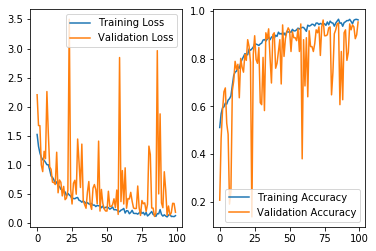

In [25]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [26]:
loss, accuracy = model.evaluate(X_test, Y_test)



604/604 [==============================] - ETA: 1s - loss: 0.1202 - acc: 0.937 - ETA: 0s - loss: 0.1593 - acc: 0.946 - ETA: 0s - loss: 0.1781 - acc: 0.949 - 0s 476us/sample - loss: 0.1636 - acc: 0.9520


In [27]:
accuracy

0.95198673

<h2>Evaluate Best Model</h2>

[[  4   0   1   0   0   0   0   0]
 [  0  23   0   0   1   0   1   0]
 [  0   0  21   0   0   0   1   0]
 [  0   0   2  55   0   1   0   2]
 [  0   0   0   0 329   0   1   3]
 [  0   4   0   1   1  48   0   0]
 [  0   0   2   0   1   0  21   0]
 [  0   0   1   0   4   0   2  74]]


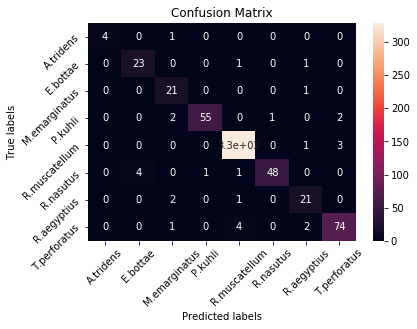

In [28]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [29]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9519867549668874


In [30]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      0.80      0.89         5
     E.bottae       0.85      0.92      0.88        25
M.emarginatus       0.78      0.95      0.86        22
      P.kuhli       0.98      0.92      0.95        60
R.muscatellum       0.98      0.99      0.98       333
    R.nasutus       0.98      0.89      0.93        54
  R.aegyptius       0.81      0.88      0.84        24
 T.perforatus       0.94      0.91      0.92        81

     accuracy                           0.95       604
    macro avg       0.91      0.91      0.91       604
 weighted avg       0.95      0.95      0.95       604



<h2>K-Fold Training and Evaluation</h2>

In [32]:
def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model


In [33]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 85, 120)       480       
_________________________________________________________________
activation_7 (Activation)    (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 22, 96)        2880

In [34]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=75,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/75
2172/2172 - 4s - loss: 1.5958 - acc: 0.5069 - val_loss: 1.5497 - val_acc: 0.4959
Epoch 2/75
2172/2172 - 3s - loss: 1.3110 - acc: 0.5709 - val_loss: 2.1964 - val_acc: 0.2769
Epoch 3/75
2172/2172 - 3s - loss: 1.1535 - acc: 0.6041 - val_loss: 1.1954 - val_acc: 0.6074
Epoch 4/75
2172/2172 - 3s - loss: 1.1028 - acc: 0.6202 - val_loss: 1.4447 - val_acc: 0.5289
Epoch 5/75
2172/2172 - 3s - loss: 1.0695 - acc: 0.6289 - val_loss: 1.4285 - val_acc: 0.5702
Epoch 6/75
2172/2172 - 3s - loss: 1.0598 - acc: 0.6169 - val_loss: 0.9133 - val_acc: 0.6612
Epoch 7/75
2172/2172 - 3s - loss: 0.9660 - acc: 0.6464 - val_loss: 1.4187 - val_acc: 0.4339
Epoch 8/75
2172/2172 - 3s - loss: 0.9365 - acc: 0.6814 - val_loss: 1.7174 - val_acc: 0.4917
Epoch 9/75
2172/2172 - 3s - loss: 0.8629 - acc: 0.7017 - val_loss: 1.2227 - val_acc: 0.6157
Epoch 10/75
2172/2172 - 3s - loss: 0.8095 - acc: 0.7155 - val_loss: 1.8372 - val_acc: 0.3430
Epoch 11/75
2172/2172 - 3s - los

Epoch 14/75
2172/2172 - 3s - loss: 0.7174 - acc: 0.7620 - val_loss: 0.6270 - val_acc: 0.8182
Epoch 15/75
2172/2172 - 3s - loss: 0.6727 - acc: 0.7753 - val_loss: 0.6818 - val_acc: 0.7603
Epoch 16/75
2172/2172 - 3s - loss: 0.6707 - acc: 0.7767 - val_loss: 0.6878 - val_acc: 0.7645
Epoch 17/75
2172/2172 - 3s - loss: 0.6540 - acc: 0.7808 - val_loss: 0.6211 - val_acc: 0.8017
Epoch 18/75
2172/2172 - 3s - loss: 0.5977 - acc: 0.8085 - val_loss: 1.1392 - val_acc: 0.6694
Epoch 19/75
2172/2172 - 3s - loss: 0.5810 - acc: 0.8062 - val_loss: 0.5848 - val_acc: 0.8430
Epoch 20/75
2172/2172 - 3s - loss: 0.5694 - acc: 0.8020 - val_loss: 1.2582 - val_acc: 0.6116
Epoch 21/75
2172/2172 - 3s - loss: 0.5592 - acc: 0.8181 - val_loss: 0.8191 - val_acc: 0.7603
Epoch 22/75
2172/2172 - 3s - loss: 0.5151 - acc: 0.8154 - val_loss: 0.7665 - val_acc: 0.7851
Epoch 23/75
2172/2172 - 3s - loss: 0.5172 - acc: 0.8218 - val_loss: 0.5700 - val_acc: 0.7893
Epoch 24/75
2172/2172 - 3s - loss: 0.5066 - acc: 0.8287 - val_loss: 0.

Epoch 27/75
2172/2172 - 3s - loss: 0.4700 - acc: 0.8435 - val_loss: 0.3568 - val_acc: 0.8926
Epoch 28/75
2172/2172 - 3s - loss: 0.4209 - acc: 0.8600 - val_loss: 0.5846 - val_acc: 0.8140
Epoch 29/75
2172/2172 - 3s - loss: 0.4087 - acc: 0.8614 - val_loss: 0.6131 - val_acc: 0.7645
Epoch 30/75
2172/2172 - 3s - loss: 0.4561 - acc: 0.8633 - val_loss: 0.3264 - val_acc: 0.8967
Epoch 31/75
2172/2172 - 3s - loss: 0.3866 - acc: 0.8679 - val_loss: 0.3790 - val_acc: 0.8719
Epoch 32/75
2172/2172 - 3s - loss: 0.3769 - acc: 0.8766 - val_loss: 0.5861 - val_acc: 0.8058
Epoch 33/75
2172/2172 - 3s - loss: 0.3975 - acc: 0.8762 - val_loss: 0.4993 - val_acc: 0.8182
Epoch 34/75
2172/2172 - 3s - loss: 0.3718 - acc: 0.8729 - val_loss: 0.4438 - val_acc: 0.8223
Epoch 35/75
2172/2172 - 3s - loss: 0.3483 - acc: 0.8858 - val_loss: 0.3086 - val_acc: 0.8843
Epoch 36/75
2172/2172 - 3s - loss: 0.3526 - acc: 0.8835 - val_loss: 0.2570 - val_acc: 0.9008
Epoch 37/75
2172/2172 - 3s - loss: 0.3607 - acc: 0.8794 - val_loss: 0.

Epoch 40/75
2173/2173 - 3s - loss: 0.3325 - acc: 0.8896 - val_loss: 0.2923 - val_acc: 0.8843
Epoch 41/75
2173/2173 - 3s - loss: 0.3421 - acc: 0.8937 - val_loss: 0.4998 - val_acc: 0.8512
Epoch 42/75
2173/2173 - 3s - loss: 0.3089 - acc: 0.8978 - val_loss: 0.6656 - val_acc: 0.7521
Epoch 43/75
2173/2173 - 3s - loss: 0.3302 - acc: 0.8914 - val_loss: 0.7988 - val_acc: 0.7149
Epoch 44/75
2173/2173 - 3s - loss: 0.3015 - acc: 0.9001 - val_loss: 0.1942 - val_acc: 0.9463
Epoch 45/75
2173/2173 - 3s - loss: 0.2582 - acc: 0.9139 - val_loss: 0.8059 - val_acc: 0.7149
Epoch 46/75
2173/2173 - 3s - loss: 0.2926 - acc: 0.9080 - val_loss: 0.4501 - val_acc: 0.8264
Epoch 47/75
2173/2173 - 3s - loss: 0.2523 - acc: 0.9158 - val_loss: 0.3759 - val_acc: 0.8719
Epoch 48/75
2173/2173 - 3s - loss: 0.2686 - acc: 0.9204 - val_loss: 0.4182 - val_acc: 0.8512
Epoch 49/75
2173/2173 - 3s - loss: 0.2571 - acc: 0.9158 - val_loss: 0.2015 - val_acc: 0.9421
Epoch 50/75
2173/2173 - 3s - loss: 0.2738 - acc: 0.9089 - val_loss: 0.

Epoch 53/75
2173/2173 - 3s - loss: 0.2279 - acc: 0.9268 - val_loss: 0.4006 - val_acc: 0.8471
Epoch 54/75
2173/2173 - 3s - loss: 0.2059 - acc: 0.9360 - val_loss: 0.9068 - val_acc: 0.7231
Epoch 55/75
2173/2173 - 3s - loss: 0.2359 - acc: 0.9305 - val_loss: 0.1591 - val_acc: 0.9587
Epoch 56/75
2173/2173 - 3s - loss: 0.1822 - acc: 0.9434 - val_loss: 0.4806 - val_acc: 0.8554
Epoch 57/75
2173/2173 - 3s - loss: 0.2293 - acc: 0.9305 - val_loss: 0.2246 - val_acc: 0.9380
Epoch 58/75
2173/2173 - 3s - loss: 0.2016 - acc: 0.9402 - val_loss: 1.8488 - val_acc: 0.4504
Epoch 59/75
2173/2173 - 3s - loss: 0.2403 - acc: 0.9282 - val_loss: 0.4827 - val_acc: 0.8430
Epoch 60/75
2173/2173 - 3s - loss: 0.2004 - acc: 0.9356 - val_loss: 0.4532 - val_acc: 0.8595
Epoch 61/75
2173/2173 - 3s - loss: 0.2315 - acc: 0.9310 - val_loss: 0.2191 - val_acc: 0.9256
Epoch 62/75
2173/2173 - 3s - loss: 0.1721 - acc: 0.9416 - val_loss: 0.8975 - val_acc: 0.7355
Epoch 63/75
2173/2173 - 3s - loss: 0.2263 - acc: 0.9287 - val_loss: 0.

In [35]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.96       0.88801561 0.41498155 0.91017236 0.92794747 0.97507504
 0.8358046  0.88696562]
precision sdev by class [0.08       0.12734021 0.17838934 0.0288549  0.03503506 0.01995843
 0.13538473 0.09100943]
macro precision mean 0.8498702795308424
macro precision sdev 0.029625172106134235
recall mean [0.8        0.758      0.79288538 0.76497175 0.96576577 0.83284416
 0.462      0.70996914]
recall sdev [0.12649111 0.076      0.15447114 0.16439756 0.02982513 0.08744414
 0.24146175 0.1547252 ]
macro recall mean 0.7608045241742966
macro recall sdev 0.043664828815872206
f1 mean [0.86555556 0.81292517 0.49867071 0.81900548 0.94543653 0.89537617
 0.53048192 0.77662112]
f1 sdev [0.08580771 0.07874719 0.09397159 0.0985455  0.00910321 0.04861012
 0.2117875  0.12110562]
macro f1 mean 0.7680090810239505
macro f1 sdev 0.05563637910481682
accuracy mean 0.86351026325327
accuracy sdev 0.032564193206758255


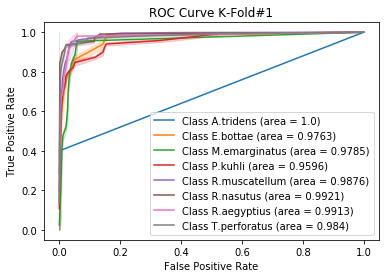

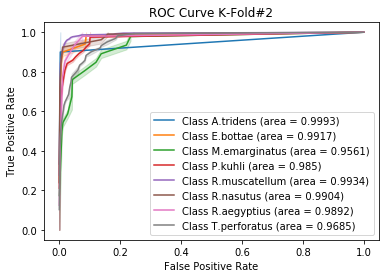

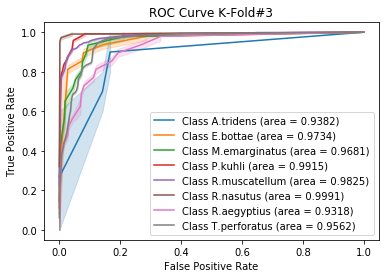

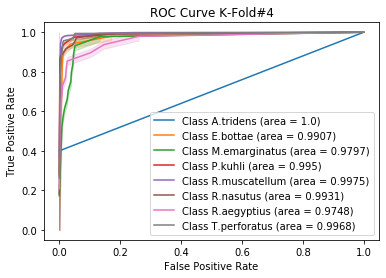

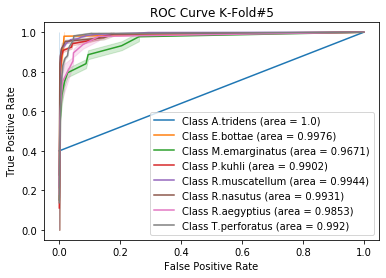

In [36]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

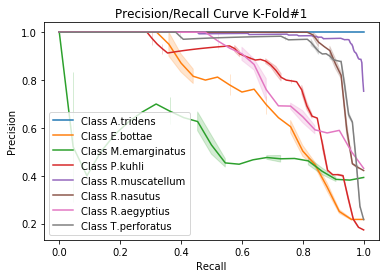

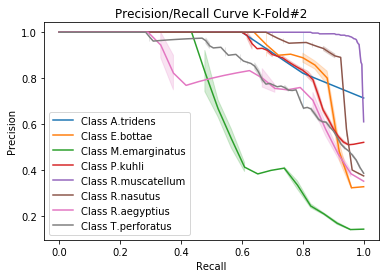

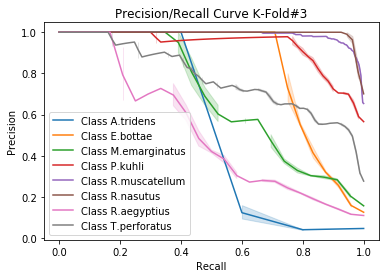

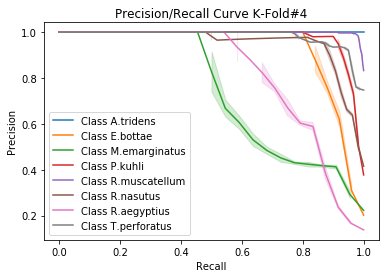

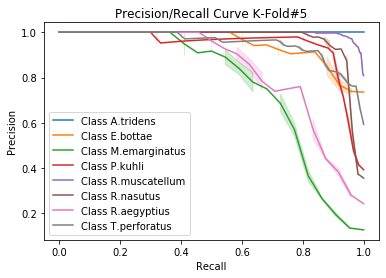

In [37]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  17   0   0   8   0   0   0]
 [  0   0  19   0   1   0   0   2]
 [  0   8  15  29   7   0   0   0]
 [  0   0   1   0 331   0   0   1]
 [  0   1   0   2  13  38   0   0]
 [  0   0   5   0   6   0  14   0]
 [  0   0   5   0   9   0   1  66]]


Confusion Matrix K-Fold #2

[[  4   0   1   0   0   0   0   0]
 [  0  20   2   0   0   3   0   0]
 [  0   0  19   0   3   0   1   0]
 [  0   0  19  41   0   0   0   0]
 [  0   1   6   1 304   0   0  21]
 [  0   2   3   2   0  46   0   0]
 [  1   0  12   0   0   0   7   4]
 [  0   0  16   0   1   0   0  64]]


Confusion Matrix K-Fold #3

[[  3   0   2   0   0   0   0   0]
 [  0  18   1   0   5   0   0   0]
 [  0   0  22   1   0   0   0   0]
 [  0   0  11  48   0   1   0   0]
 [  0   0  10   0 318   0   0   5]
 [  0   0   0   1   1  52   0   0]
 [  0   0  14   3   5   0   2   0]
 [  0   0  29   1  18   0   0  33]]


Confusion Matrix K-Fold #4

[[  4   0   0   0   0   0   1   0]
 [  

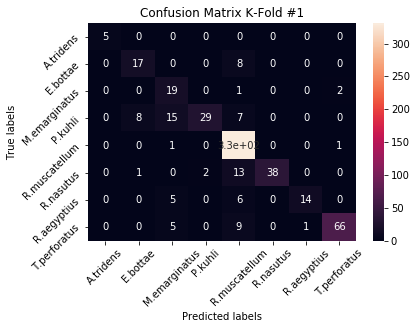

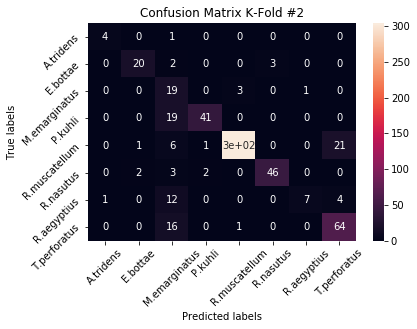

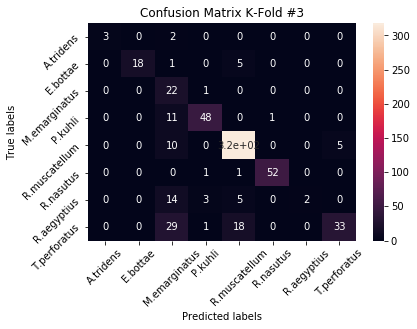

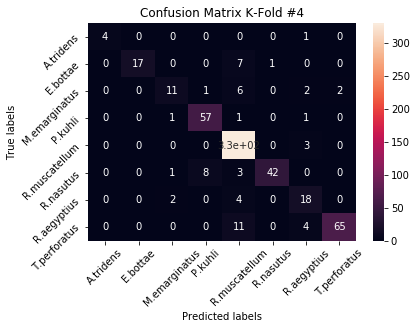

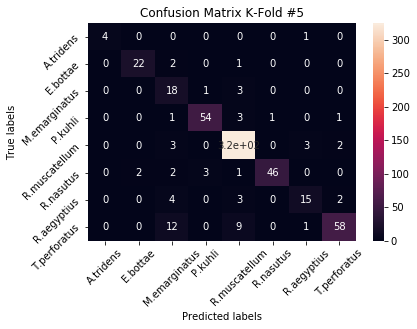

In [38]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  20    0    3    0    0    0    2    0]
 [   0   94    5    0   21    4    0    0]
 [   0    0   89    3   13    0    3    4]
 [   0    8   47  229   11    2    1    1]
 [   0    1   20    1 1608    0    6   29]
 [   0    5    6   16   18  224    0    0]
 [   1    0   37    3   18    0   56    6]
 [   0    0   62    1   48    0    6  286]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  18   1   0   4   0   0   0]
 [  0   0  17   0   2   0   0   0]
 [  0   1   9  45   2   0   0   0]
 [  0   0   4   0 321   0   1   5]
 [  0   1   1   3   3  44   0   0]
 [  0   0   7   0   3   0  11   1]
 [  0   0  12   0   9   0   1  57]]


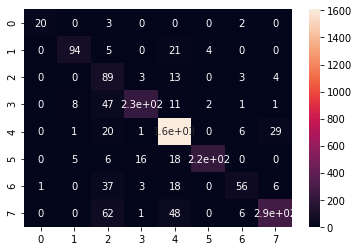

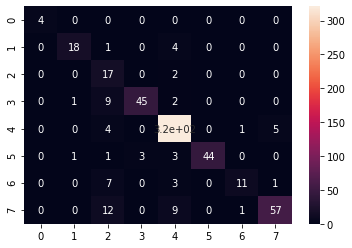

In [39]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.8  0.   0.12 0.   0.   0.   0.08 0.  ]
 [0.   0.76 0.04 0.   0.17 0.03 0.   0.  ]
 [0.   0.   0.79 0.03 0.12 0.   0.03 0.04]
 [0.   0.03 0.16 0.77 0.04 0.01 0.   0.  ]
 [0.   0.   0.01 0.   0.97 0.   0.   0.02]
 [0.   0.02 0.02 0.06 0.07 0.83 0.   0.  ]
 [0.01 0.   0.31 0.02 0.15 0.   0.46 0.05]
 [0.   0.   0.15 0.   0.12 0.   0.01 0.71]]


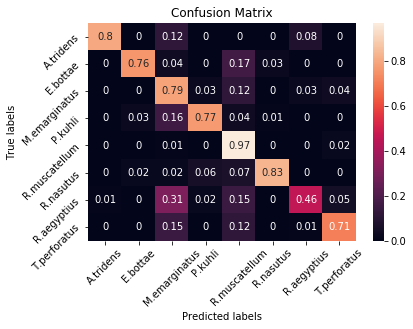

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [ ]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model